<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/GenerateAndSelectFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit # Order of installment was important now it should work
!pip install networkx==3.2
!pip install mordred
!pip install numpy==1.26.4


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mordred 1.2.0 requires numpy==1.*, but you have numpy 2.2.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached networkx-3.2-py3-none-any.whl.metadata (5.2 kB)
Using cached

In [ ]:
#Import packages

import pandas as pd
import re
import numpy as np
import os
from google.colab import drive
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
import matplotlib.pyplot as plt
import math
RDLogger.DisableLog("rdApp.info")

from rdkit.Chem import Descriptors, rdMolDescriptors
from mordred import Calculator, descriptors

In [ ]:
#Get data export from AODB by adding it (locally) or in drive (colab needs to be connected to drive)
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
#RUN THIS CELL IF func.py CHANGES

#get functions from functions file (still have to move most of the functions there!)
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/df_dpph.csv


#from func import is_substruct_in, convert_smiles_series_to_fp_to_np_array, convert_smiles_series_to_fp_to_np_array_exception_handling
#why import functions one by one?
#could be executed alternatively by:
%run func.py


--2025-05-05 09:32:41--  https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py [following]
--2025-05-05 09:32:41--  https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6467 (6.3K) [text/plain]
Saving to: ‘func.py’

func.py             100%[===================>]   6.32K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-05-05 09:32:41 (70.9 MB/s) - ‘func.py’ sav

# Import and transform df from datacuration
* get rid of metadata
* only keep smiles, pIC50
* generate activity column based on chosen threshold

In [ ]:
csv_path = '/content/drive/MyDrive/connected_df.csv'

#Read in the csv
df = pd.read_csv(csv_path)
#make a df containing only smiles and pIC50
df = df[['canonical_Smiles', 'pIC50']]
df

,canonical_Smiles,pIC50
0,Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.646630
1,C/C(=C/O[C@@H]1O[C@H](COC(=O)c2cc(O)c(O)c(O)c2...,4.502131
2,C/C(=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1)C1CC1,2.899629
3,C/C(=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1)C1CCCCC1,2.869666
4,C/C(CC(C)C)=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1,2.869666
...,...,...
1356,c1ccc(C2COc3cccc4c3N2CCC4)cc1,4.103474
1357,c1ccc(CN(Cc2ccccc2)c2ccc(N(Cc3ccccc3)Cc3ccccc3...,3.840734
1358,c1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.493438
1359,c1ccc2c3c([nH]c2c1)-c1cc2c(cc1C3)OCO2,4.280445


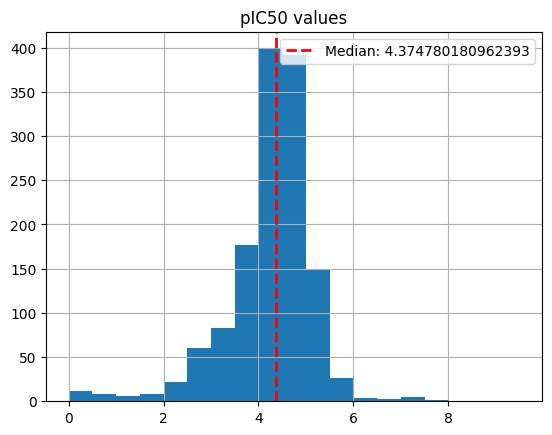

In [ ]:
median = df["pIC50"].median()

binsize = 0.5
bins = np.arange(0, 10, binsize)       #most of the compounds (>4000) occure only once or twice --> excluded for better readability of histogram
plt.hist(df['pIC50'], bins=bins)
plt.axvline(x = median, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median}")
plt.title("pIC50 values")
plt.legend()
plt.grid()
plt.show()

In [ ]:
activity_threshold = median
print(f"Activity threshold: {activity_threshold}")

#predict activity 1 or 0
df['active'] = df['pIC50'].apply(lambda pic50: 0 if pic50 < activity_threshold else 1)

Activity threshold: 4.374780180962393


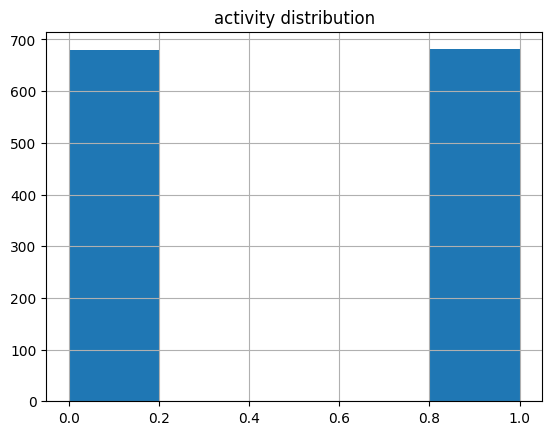

In [ ]:
binsize = 0.2
bins = np.arange(0, 1.1, binsize)
plt.hist(df['active'], bins=bins)
plt.title("activity distribution")
plt.grid()
plt.show()

# Generate features
* all from RDKit
* all from mordred
* and add all the the same dataframe

In [ ]:
# prompt: provide a code that generates some features available from rdkit for the structures given in df_curated



def generate_some_rdkit_features(smiles):
    """Generates RDKit features for a given SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES

    features = {}
    # Descriptors
    features['MolWt'] = Descriptors.MolWt(mol)
    features['LogP'] = Descriptors.MolLogP(mol)
    features['TPSA'] = rdMolDescriptors.CalcTPSA(mol)
    # ... add other RDKit descriptors as needed ...
    # 2D Descriptors
    features['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    features['NumHDonors'] = Descriptors.NumHDonors(mol)
    features['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
    features['RingCount'] = Descriptors.RingCount(mol)

    # Topological Descriptors
    features['BalabanJ'] = Descriptors.BalabanJ(mol)
    features['BertzCT'] = Descriptors.BertzCT(mol)
    features['HallKierAlpha'] = Descriptors.HallKierAlpha(mol)


    # ... add other relevant features ...

    return features



In [ ]:
# prompt: provide a code that generates all features available from rdkit for the structures given in df_curated

def calculate_rdkit_descriptors_from_mol(smiles):
    """Generates RDKit features for a given SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES

    features = Descriptors.CalcMolDescriptors(mol)

    return features

def generate_all_rdkit_features(df):
    """
    Calculates all RDKit features for molecules in a DataFrame and adds them as columns.

    Args:
        df: Input DataFrame with a 'canonical_Smiles' column.

    Returns:
        DataFrame with added RDKit features as individual columns.
    """

    # Apply the calculate_rdkit_descriptors_from_mol function to the 'canonical_Smiles' column
    df['features'] = df['canonical_Smiles'].apply(calculate_rdkit_descriptors_from_mol)

    # Expand the features dictionary into separate columns
    features_df = pd.DataFrame(df['features'].tolist(), index=df.index)  # Use index of original df

    # Concatenate the expanded features with the original DataFrame
    df = pd.concat([df, features_df], axis=1)

    # Drop the original features column
    df = df.drop('features', axis=1)

    return df

In [ ]:
df = generate_all_rdkit_features(df)
df

,canonical_Smiles,pIC50,active,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.646630,0,3.537477,3.537477,1.035833,1.035833,0.489038,12.764706,284.156,...,0,0,0,0,0,0,0,0,0,0
1,C/C(=C/O[C@@H]1O[C@H](COC(=O)c2cc(O)c(O)c(O)c2...,4.502131,1,12.045946,12.045946,0.225616,-1.752086,0.126067,27.310345,416.335,...,0,0,0,0,0,0,0,0,0,0
2,C/C(=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1)C1CC1,2.899629,0,10.794494,10.794494,0.067229,-0.404444,0.515484,15.000000,302.359,...,0,0,0,0,0,1,0,0,0,0
3,C/C(=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1)C1CCCCC1,2.869666,0,10.875061,10.875061,0.070531,-0.395976,0.465404,16.125000,344.440,...,0,0,0,0,0,1,0,0,0,0
4,C/C(CC(C)C)=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1,2.869666,0,10.812799,10.812799,0.060933,-0.408137,0.481019,11.727273,318.402,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,c1ccc(C2COc3cccc4c3N2CCC4)cc1,4.103474,0,5.995612,5.995612,0.356620,0.356620,0.767898,20.631579,251.329,...,0,0,0,0,0,0,0,0,0,0
1357,c1ccc(CN(Cc2ccccc2)c2ccc(N(Cc3ccccc3)Cc3ccccc3...,3.840734,0,2.451566,2.451566,0.867883,0.867883,0.204247,10.666667,468.644,...,0,0,0,0,0,0,0,0,0,0
1358,c1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.493438,0,3.532222,3.532222,1.065000,1.065000,0.449856,12.750000,205.260,...,0,0,0,0,0,0,0,0,0,0
1359,c1ccc2c3c([nH]c2c1)-c1cc2c(cc1C3)OCO2,4.280445,0,5.476705,5.476705,0.331136,0.331136,0.517514,14.736842,249.269,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# prompt: provide a function to calculate all 2D descriptors from mordred using the smiles from the df dataframe and append the calculated features to the same dataframe



def generate_mordred_descriptors(df):
    """Calculates all 2D descriptors from Mordred and appends them to the DataFrame.

    Args:
        df: Input DataFrame with a 'canonical_Smiles' column.

    Returns:
        DataFrame with added Mordred descriptors.
    """

    calc = Calculator(descriptors, ignore_3D=True) # Initialize Mordred calculator (2D only)

    # Calculate descriptors for valid molecules
    def calculate_mordred_descriptors_for_mol(smiles):
      mol = Chem.MolFromSmiles(smiles)
      if mol is not None:
          return calc(mol)
      else:
          return None  # Return None for invalid SMILES

    df['mordred_descriptors'] = df['canonical_Smiles'].apply(calculate_mordred_descriptors_for_mol)

    # Expand the Mordred descriptor dictionary into separate columns
    mordred_df = pd.DataFrame(df['mordred_descriptors'].tolist())

    # Concatenate the expanded features with the original DataFrame
    df = pd.concat([df, mordred_df], axis=1)

    # Drop the original mordred_descriptors column
    df = df.drop('mordred_descriptors', axis=1)

    return df




In [ ]:
# Example usage (assuming 'df' is your DataFrame):
df = generate_mordred_descriptors(df)
df.head()

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,canonical_Smiles,pIC50,active,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.646630,0,3.537477,3.537477,1.035833,1.035833,0.489038,12.764706,284.156,...,10.031045,67.111146,282.999661,10.481469,471,28,100.0,124.0,4.027778,3.555556
1,C/C(=C/O[C@@H]1O[C@H](COC(=O)c2cc(O)c(O)c(O)c2...,4.502131,1,12.045946,12.045946,0.225616,-1.752086,0.126067,27.310345,416.335,...,10.236418,64.355228,416.095476,8.491744,2478,48,146.0,170.0,13.083333,6.388889
2,C/C(=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1)C1CC1,2.899629,0,10.794494,10.794494,0.067229,-0.404444,0.515484,15.000000,302.359,...,9.832367,74.075943,302.083747,8.630964,1054,28,110.0,128.0,6.527778,4.583333
3,C/C(=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1)C1CCCCC1,2.869666,0,10.875061,10.875061,0.070531,-0.395976,0.465404,16.125000,344.440,...,9.884967,71.723238,344.130697,7.821152,1555,33,122.0,140.0,7.277778,5.333333
4,C/C(CC(C)C)=N/Nc1nc(-c2cccc([N+](=O)[O-])c2)cs1,2.869666,0,10.812799,10.812799,0.060933,-0.408137,0.481019,11.727273,318.402,...,9.696279,68.979122,318.115047,7.952876,1231,28,108.0,121.0,8.277778,4.888889


In [ ]:
# make two dataframes X with features, Y with target ('active')

Y = df["active"]
X = df.drop(['canonical_Smiles', 'pIC50', 'active'], axis=1)

# Feature selection
* Remove semi-constant features (>= 80% of column values the same after Lu, A. (2022) https://doi.org/10.1038/s41598-022-11925-y)
* Remove highly correlating columns. Threshold to be discussed, maybe 0.75?


In [ ]:
# prompt: proviede code that drops columns from a dataframe if 80% or more of the values are the same

def remove_semi_constant_features(df, semi_constant_threshold):
    """Removes columns from a Pandas DataFrame where 80% or more of the values are the same.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with the single-value columns removed.
    """

    cols_to_drop = []
    for col in df.columns:
        try:
            # Calculate the percentage of the most frequent value
            counts = df[col].value_counts(normalize=True)
            if counts.iloc[0] >= semi_constant_threshold:
                cols_to_drop.append(col)
        except (TypeError, IndexError):
            pass  # Handle cases where value_counts fails (e.g., mixed data types)

    return df.drop(columns=cols_to_drop)


In [ ]:
X = remove_semi_constant_features(X, semi_constant_threshold=0.8)
X

,pIC50,active,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,1602,1603,1604,1605,1606,1607,1608,1609,1610,1612
0,3.646630,0,3.537477,3.537477,1.035833,1.035833,0.489038,12.764706,284.156,274.076,...,7.742836,10.031045,67.111146,282.999661,10.481469,471,28,100.0,124.0,3.555556
1,4.502131,1,12.045946,12.045946,0.225616,-1.752086,0.126067,27.310345,416.335,396.175,...,0.000000,10.236418,64.355228,416.095476,8.491744,2478,48,146.0,170.0,6.388889
2,2.899629,0,10.794494,10.794494,0.067229,-0.404444,0.515484,15.000000,302.359,288.247,...,7.647309,9.832367,74.075943,302.083747,8.630964,1054,28,110.0,128.0,4.583333
3,2.869666,0,10.875061,10.875061,0.070531,-0.395976,0.465404,16.125000,344.440,324.280,...,6.580639,9.884967,71.723238,344.130697,7.821152,1555,33,122.0,140.0,5.333333
4,2.869666,0,10.812799,10.812799,0.060933,-0.408137,0.481019,11.727273,318.402,300.258,...,6.580639,9.696279,68.979122,318.115047,7.952876,1231,28,108.0,121.0,4.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,4.103474,0,5.995612,5.995612,0.356620,0.356620,0.767898,20.631579,251.329,234.193,...,0.000000,10.099671,53.097088,251.131014,6.975862,636,33,106.0,129.0,4.138889
1357,3.840734,0,2.451566,2.451566,0.867883,0.867883,0.204247,10.666667,468.644,436.388,...,0.000000,10.273705,72.157325,468.256549,6.886126,4322,51,184.0,210.0,8.055556
1358,3.493438,0,3.532222,3.532222,1.065000,1.065000,0.449856,12.750000,205.260,194.172,...,7.742836,9.963123,65.794818,205.089149,7.595894,391,26,94.0,117.0,3.388889
1359,4.280445,0,5.476705,5.476705,0.331136,0.331136,0.517514,14.736842,249.269,238.181,...,8.014666,10.203111,70.880402,249.078979,8.302633,639,32,116.0,146.0,3.916667


In [ ]:
# prompt: drop columns from df that do not contain numeric values

def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df


In [ ]:
X = drop_non_numeric_columns(X)
X

,pIC50,active,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,1602,1603,1604,1605,1606,1607,1608,1609,1610,1612
0,3.646630,0,3.537477,3.537477,1.035833,1.035833,0.489038,12.764706,284.156,274.076,...,7.742836,10.031045,67.111146,282.999661,10.481469,471,28,100.0,124.0,3.555556
1,4.502131,1,12.045946,12.045946,0.225616,-1.752086,0.126067,27.310345,416.335,396.175,...,0.000000,10.236418,64.355228,416.095476,8.491744,2478,48,146.0,170.0,6.388889
2,2.899629,0,10.794494,10.794494,0.067229,-0.404444,0.515484,15.000000,302.359,288.247,...,7.647309,9.832367,74.075943,302.083747,8.630964,1054,28,110.0,128.0,4.583333
3,2.869666,0,10.875061,10.875061,0.070531,-0.395976,0.465404,16.125000,344.440,324.280,...,6.580639,9.884967,71.723238,344.130697,7.821152,1555,33,122.0,140.0,5.333333
4,2.869666,0,10.812799,10.812799,0.060933,-0.408137,0.481019,11.727273,318.402,300.258,...,6.580639,9.696279,68.979122,318.115047,7.952876,1231,28,108.0,121.0,4.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,4.103474,0,5.995612,5.995612,0.356620,0.356620,0.767898,20.631579,251.329,234.193,...,0.000000,10.099671,53.097088,251.131014,6.975862,636,33,106.0,129.0,4.138889
1357,3.840734,0,2.451566,2.451566,0.867883,0.867883,0.204247,10.666667,468.644,436.388,...,0.000000,10.273705,72.157325,468.256549,6.886126,4322,51,184.0,210.0,8.055556
1358,3.493438,0,3.532222,3.532222,1.065000,1.065000,0.449856,12.750000,205.260,194.172,...,7.742836,9.963123,65.794818,205.089149,7.595894,391,26,94.0,117.0,3.388889
1359,4.280445,0,5.476705,5.476705,0.331136,0.331136,0.517514,14.736842,249.269,238.181,...,8.014666,10.203111,70.880402,249.078979,8.302633,639,32,116.0,146.0,3.916667


In [ ]:
# prompt: create a code that drops columns (one each) from df that correlate to each other more than 0.75

def drop_high_correlation_columns(df, threshold=0.75):
    """Drops columns from a DataFrame that have a correlation above a specified threshold.

    Args:
        df: The input DataFrame.
        threshold: The correlation threshold above which columns are dropped.

    Returns:
        A new DataFrame with highly correlated columns removed.
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than 0.75
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features
    return df.drop(columns=to_drop)

In [ ]:
# Assuming 'df' is your DataFrame
X = drop_high_correlation_columns(X)
X


,pIC50,active,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,...,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576
0,3.646630,0,3.537477,1.035833,1.035833,0.489038,12.764706,284.156,0.050320,-0.354276,...,0.150000,0.066667,0.058780,0.037884,0.034741,0.011956,0.017736,0.012346,0.015625,0.000000
1,4.502131,1,12.045946,0.225616,-1.752086,0.126067,27.310345,416.335,0.337998,-0.504144,...,0.250000,0.118863,0.050781,0.055789,0.030159,0.019773,0.018615,0.012679,0.010280,0.010666
2,2.899629,0,10.794494,0.067229,-0.404444,0.515484,15.000000,302.359,0.269602,-0.258309,...,0.195652,0.078544,0.041667,0.036759,0.027778,0.012796,0.015627,0.010413,0.006146,0.008264
3,2.869666,0,10.875061,0.070531,-0.395976,0.465404,16.125000,344.440,0.269602,-0.258309,...,0.173077,0.076190,0.035143,0.032701,0.028169,0.012485,0.012983,0.010303,0.005898,0.005789
4,2.869666,0,10.812799,0.060933,-0.408137,0.481019,11.727273,318.402,0.269602,-0.258309,...,0.239130,0.071685,0.043651,0.036934,0.025324,0.017925,0.017363,0.011289,0.010365,0.009633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,4.103474,0,5.995612,0.356620,0.356620,0.767898,20.631579,251.329,0.142527,-0.488892,...,0.090909,0.064516,0.039773,0.029732,0.016002,0.012551,0.007260,0.006450,0.000000,0.000000
1357,3.840734,0,2.451566,0.867883,0.867883,0.204247,10.666667,468.644,0.043275,-0.362872,...,0.125000,0.042735,0.024510,0.028889,0.016569,0.006327,0.005556,0.010204,0.004125,0.003920
1358,3.493438,0,3.532222,1.065000,1.065000,0.449856,12.750000,205.260,0.050318,-0.354276,...,0.105263,0.063492,0.056090,0.031813,0.027778,0.007811,0.006774,0.000000,0.000000,0.000000
1359,4.280445,0,5.476705,0.331136,0.331136,0.517514,14.736842,249.269,0.230801,-0.453584,...,0.130435,0.063492,0.051649,0.037667,0.023278,0.014815,0.012153,0.004789,0.002186,0.000000
